# Graphs Corruption Notebook
------------------
This notebook contains the code used to generate the graphs for the report. 

Different plots were generated in order to analyze the results of the project.

The code was then adapted into different plotting functions that can be found in Functions/visualization.py

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from CSV files
# and prepare it for visualization
folder_path = './Results_Corruption'
model_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
model_names = [os.path.splitext(f)[0] for f in model_files]

corruption_list = sorted(list({
    row['corruption']
    for file in model_files
    for _, row in pd.read_csv(os.path.join(folder_path, file)).iterrows()
}))

corruption_to_idx = {name: idx for idx, name in enumerate(corruption_list)}

n_corruptions = len(corruption_list)
n_severities = 5
n_models = len(model_files)

# Initialize the table containing all the data (n_models, n_corruptions, n_severities)
all_data = np.zeros((n_models, n_corruptions, n_severities))

for i, file in enumerate(model_files): # Loop through each model file and fill the table
    df = pd.read_csv(os.path.join(folder_path, file))
    for _, row in df.iterrows():
        c_idx = corruption_to_idx[row['corruption']]
        s_idx = int(row['severity']) - 1
        all_data[i, c_idx, s_idx] = row['f1_macro']


In [ ]:
# Check if the data is ordered correctly
print("Ordre des modèles (model_names) :")
for i, name in enumerate(model_names):
    print(f"{i}: {name}")

Ordre des modèles (model_names) :
0: DenseNet_AdaGrad
1: DenseNet_Adam
2: DenseNet_SGD
3: ResNet_AdaGrad
4: ResNet_Adam
5: ResNet_SGD
6: VGGLike_AdaGrad
7: VGGLike_Adam
8: VGGLike_SGD


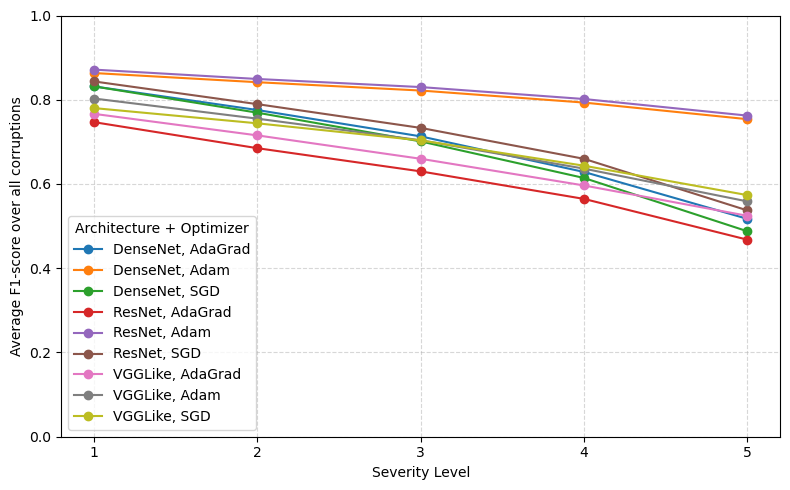

In [ ]:
"""First plot, showing the average F1-score for each severity level"""

mean_f1_per_severity = all_data.mean(axis=1)  # average over the corruption axis, resulting in shape (n_models, n_severities)

# Plotting the average F1 scores for each model across severity levels
plt.figure(figsize=(8, 5))
severities = np.arange(1, n_severities + 1)

display_names = [name.replace('_', ', ') for name in model_names]

for i, model_name in enumerate(display_names):
    plt.plot(severities, mean_f1_per_severity[i], marker='o', label=model_name)

plt.xlabel("Severity Level")
plt.ylabel("Average F1-score over all corruptions")
plt.xticks(severities)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Architecture + Optimizer")
plt.tight_layout()
plt.show()

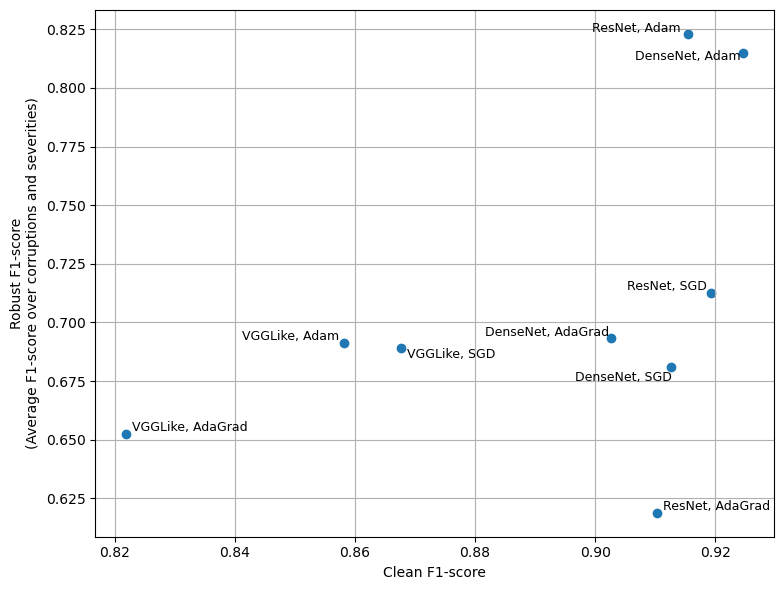

In [ ]:
"""
Clean accuracy vs Robust accuracy
    => visualize if certain models sacrifice clean accuracy for robustness, or vice versa

Axe X : Clean accuracy
Axe Y : Average robust accuracy (average over all corruptions and severities)
"""
"""
The models are assumed to be in the following order, with their corresponding clean performances:
    
0: DenseNet_AdaGrad 0.9026944891
1: DenseNet_Adam 0.9246578628644885
2: DenseNet_SGD 0.9125940113141272
3: ResNet_AdaGrad 0.910335397
4: ResNet_Adam 0.9154097303205765
5: ResNet_SGD 0.9193440341235497
6: VGGLike_AdaGrad 0.8219071213
7: VGGLike_Adam 0.8581507263642598
8: VGG_SGD 0.8676458931227247
    
The values for clean_perfs are manually set based on the clean performances of each model on the test set after training.
The data is found in the "Training results" subfolder, in the "Best models" folder.
"""

clean_perfs = np.array([0.9026944891, 0.9246578628644885, 0.9125940113141272, 0.910335397, 0.9154097303205765, 0.9193440341235497, 0.8219071213, 0.8581507263642598, 0.8676458931227247])
robust_perfs = all_data.mean(axis=(1, 2))  # average the performance over all corruptions and severities, resulting in shape (n_models,)

display_names = [name.replace('_', ', ') for name in model_names]



plt.figure(figsize=(8, 6))
plt.scatter(clean_perfs, robust_perfs)

for i, name in enumerate(display_names):
    # Default offsets for text placement
    dx, dy = 0.001, 0.001
    
    # Change text offsets based for specific models to avoid overlap
    if i == 7:
        dx = -0.017
    elif i == 8:
        dy = -0.004
        dx = 0.001
    elif i == 1:
        dx = -0.018
        dy = -0.003
    elif i == 4:
        dx = -0.016
    elif i == 2:
        dx = -0.016
        dy = -0.006
    elif i == 5:
        dx = -0.014
    elif i == 0:
        dx = -0.021

    plt.text(clean_perfs[i] + dx, robust_perfs[i] + dy, name, fontsize=9)



plt.xlabel('Clean F1-score')
plt.ylabel('Robust F1-score\n(Average F1-score over corruptions and severities)')
plt.grid(True)
plt.tight_layout()
plt.show()

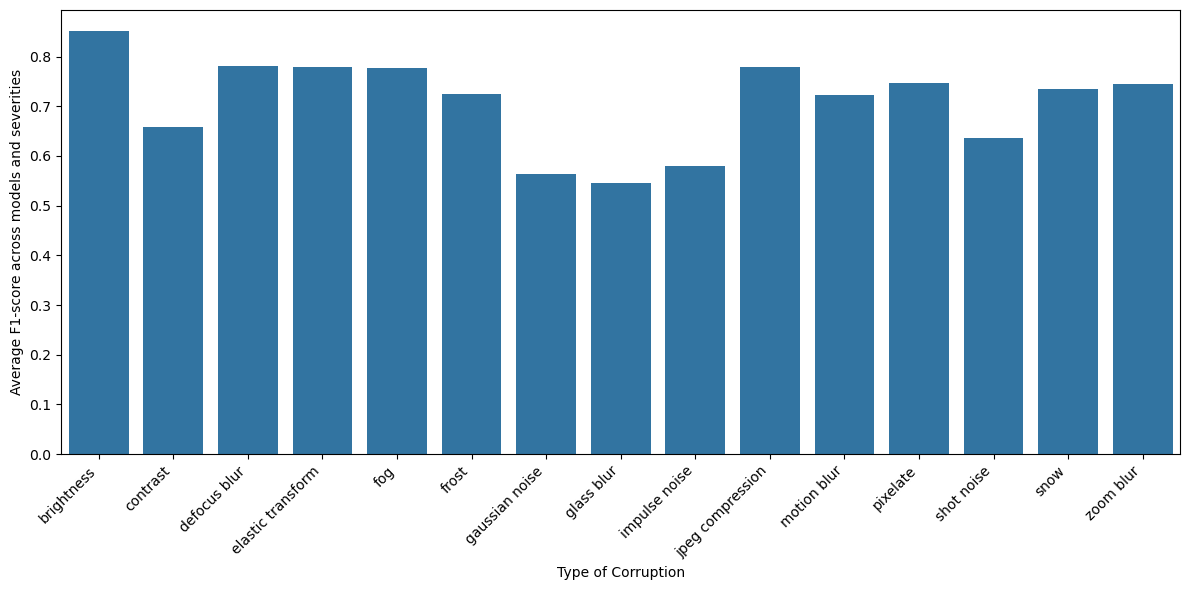

In [ ]:
"""
Average performance per corruption to identify the hardest corruptions on average.

X axis : Corruptions
Y axis : Average scores over all models and severities
"""
# Average over all models and severities : shape (15,)
corruption_means = all_data.mean(axis=(0, 2))  

display_corruption = [cor.replace('_', ' ') for cor in corruption_list]

plt.figure(figsize=(12, 6))
sns.barplot(x=display_corruption, y=corruption_means)
plt.ylabel('Average F1-score across models and severities')
plt.xlabel('Type of Corruption')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

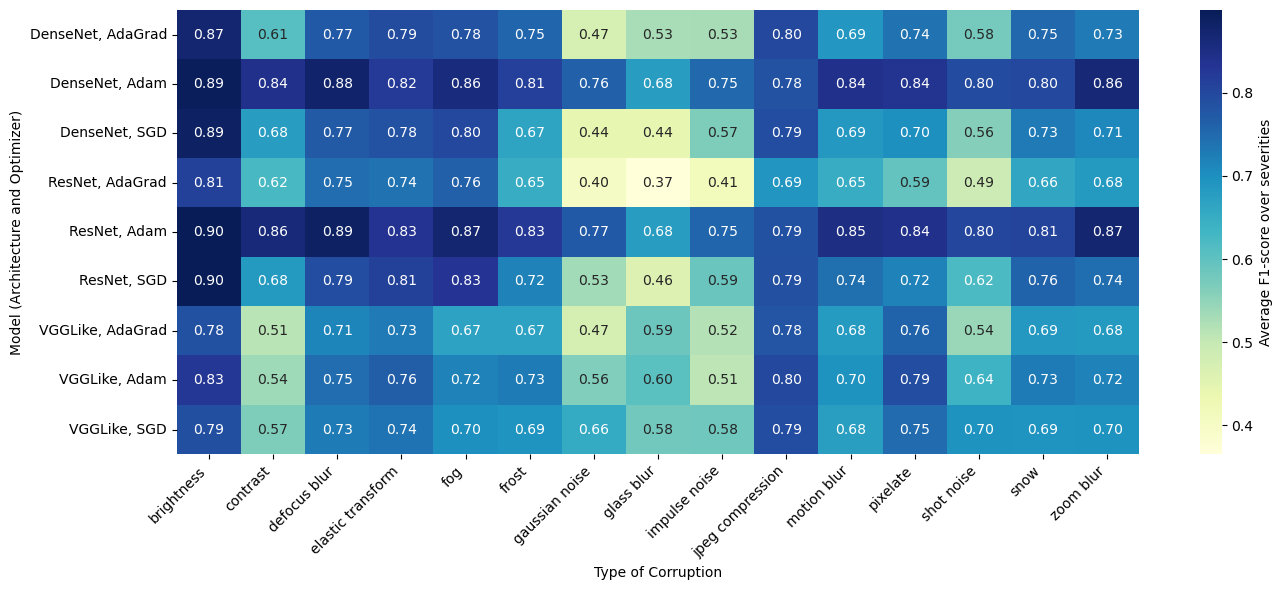

In [ ]:
"""Average performance per corruption and severity to identify the hardest corruptions for each severity level."""

avg_over_severity = all_data.mean(axis=2) # average over severity levels, resulting in shape (n_models, n_corruptions)

# Prepare the display names for models and corruptions
display_names = [name.replace('_', ', ') for name in model_names]
display_corruption = [cor.replace('_', ' ') for cor in corruption_list]

df_heatmap = pd.DataFrame(
    avg_over_severity,
    index=display_names,
    columns=display_corruption
) # Convert to DataFrame for better visualization

# Plotting the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(df_heatmap, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average F1-score over severities'})
plt.xlabel("Type of Corruption")
plt.ylabel("Model (Architecture and Optimizer)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

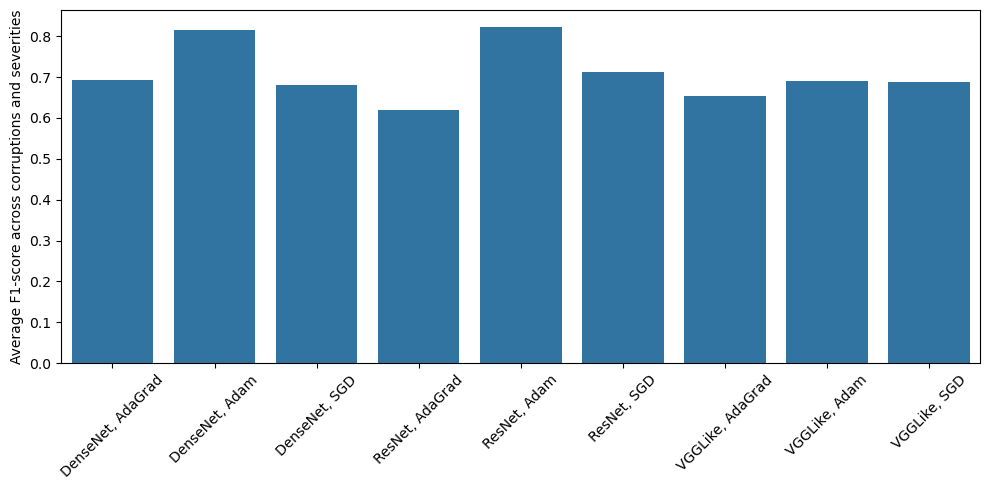

In [ ]:
"""
Global performance comparison across all models
    => visualize the overall robustness of each model

X axis : The models (architecture + optimizer)
Y axis : Average F1-score across all corruptions and severities
"""

model_means = all_data.mean(axis=(1, 2))  # mean over corruptions and severities

display_names = [name.replace('_', ', ') for name in model_names]  # ou tout autre transformation

plt.figure(figsize=(10, 5))
sns.barplot(x=display_names, y=model_means)
plt.ylabel('Average F1-score across corruptions and severities')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We can see that Adam is more robust than others through all. 

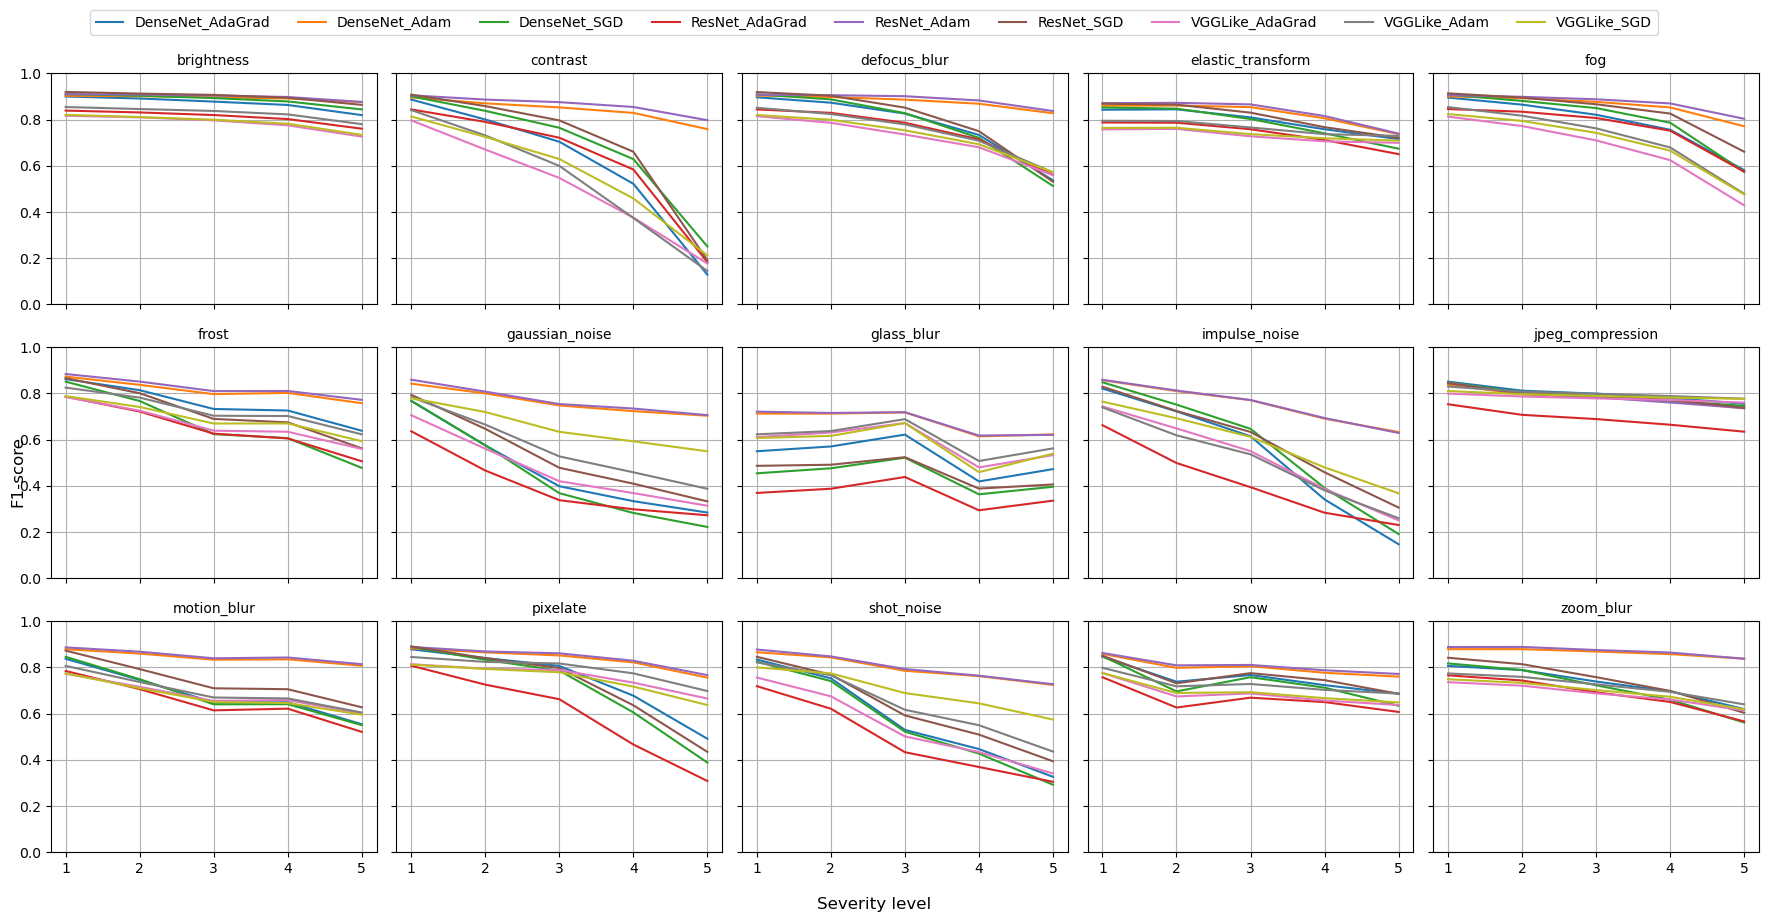

In [ ]:
"""
Degradation curves by corruption to see how each model degrades with increasing severity of a given corruption
    => shows which models withstand a specific corruption the best.

X axis : Severity levels (1 to 5)
Y axis : F1-score
"""

fig, axes = plt.subplots(3, 5, figsize=(18, 9), sharex=True, sharey=True)
axes = axes.flatten()

for c_idx, corruption in enumerate(corruption_list):
    ax = axes[c_idx]
    for m_idx, model_name in enumerate(model_names):
        ax.plot(
            range(1, 6),
            all_data[m_idx, c_idx],
            label=model_name,
            linewidth=1.5
        )
    ax.set_title(corruption, fontsize=10)
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_ylim(0, 1)
    ax.grid(True)

fig.supxlabel('Severity level', fontsize=12)
fig.supylabel('F1-score', fontsize=12)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=n_models, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()